In [ ]:
import pandas as pd

In [13]:
file_path = r"C:\Users\nivle\OneDrive\שולחן העבודה\לימודים\שנה ג'\כריית נתונים בפייתון\Matala 2\matala2_cosmetics_2019-Nov\matala2_cosmetics_2019-Nov.csv"
data = pd.read_csv(file_path)

C:\Users\nivle\AppData\Local\Temp\ipykernel_12764\1328981744.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


> #### A. Data Understanding

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635837 entries, 0 to 4635836
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   event_time     object
 1   event_type     object
 2   product_id     int64 
 3   category_id    int64 
 4   category_code  object
 5   brand          object
 6   price          object
 7   user_id        int64 
 8   user_session   object
dtypes: int64(3), object(6)
memory usage: 318.3+ MB


In [4]:
data['event_type'].unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

In [5]:
data['category_code'].unique()

array([nan, 'stationery.cartrige', 'appliances.environment.vacuum',
       'accessories.bag', 'furniture.living_room.cabinet',
       'apparel.glove', 'appliances.personal.hair_cutter',
       'furniture.bathroom.bath',
       'appliances.environment.air_conditioner',
       'furniture.living_room.chair', 'accessories.cosmetic_bag'],
      dtype=object)

In [123]:
print(f"There are {data['category_id'].nunique()} unique categories in the category_id column.")
print(f"There are {data['product_id'].nunique()} unique products in the product_id column.")
print(f"There are {data['brand'].nunique()} unique brands in the brand column.")
print(f"There are {data['user_id'].nunique()} unique users in the user_id column.")
print(f"There are {data['user_session'].nunique()} unique sessions in the user_session column.")

There are 491 unique categories in the category_id column.
There are 43419 unique products in the product_id column.
There are 239 unique brands in the brand column.
There are 368232 unique users in the user_id column.
There are 942022 unique sessions in the user_session column.


> #### B. Data Handling

In [15]:
data.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4560089
brand            1986029
price                  0
user_id                0
user_session         813
dtype: int64

In [16]:
data = data.dropna(subset=['user_session'])

In [17]:
data = data.drop('category_code', axis=1)

In [18]:
import datetime
data['event_time'] = data['event_time'].str[:-4]
data = data.rename(columns={'event_time': 'event_time - UTC'})
data['event_time - UTC'] = data['event_time - UTC'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
#df['event_time'] = pd.to_datetime(df['event_time'], utc=True)

In [19]:
data['event_time - UTC'].info()

<class 'pandas.core.series.Series'>
Int64Index: 4635024 entries, 0 to 4635836
Series name: event_time - UTC
Non-Null Count    Dtype         
--------------    -----         
4635024 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 70.7 MB


> ### C. Choosing a Sample :
> - I chose 5000 users who loged in for more than 4 days totally. 

In [20]:
#List of days login per user
days_per_user = data.groupby(['user_id'])['event_time - UTC'].apply(lambda x: x.dt.date.unique()).reset_index()
#only users who logged in more than 4 days
list_of_active_users = days_per_user[days_per_user['event_time - UTC'].apply(len) > 4].user_id.tolist()

In [23]:
#Choose 5000 users
import random
sub_list = random.sample(list_of_active_users, 5000)

In [24]:
df = data[data["user_id"].isin(sub_list)].reset_index()
df.head()

,index,event_time - UTC,event_type,product_id,category_id,brand,price,user_id,user_session
0,2,2019-11-01 00:00:10,view,5837166,1783999064103190764,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
1,8,2019-11-01 00:00:34,remove_from_cart,5870838,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
2,9,2019-11-01 00:00:37,view,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
3,10,2019-11-01 00:00:42,remove_from_cart,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
4,11,2019-11-01 00:00:46,view,5841721,1487580008187692007,NaN,1.37,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a


> ### Question 1

In [25]:
df['index'] = df.index
index = df.pop('index')
df.insert(0, 'index', index)

In [26]:
df = df.sort_values(['user_session', 'event_time - UTC'])
df['next_event_time - UTC'] = df.groupby('user_session')['event_time - UTC'].shift(-1)

# calculate the duration in seconds between each event and the next event in the same session
df['duration_to_next_event'] = (df['next_event_time - UTC'] - df['event_time - UTC']).dt.seconds
df['duration_to_next_event'] = df['duration_to_next_event'].fillna(0)

# drop the next_event_time column
df = df.drop(columns=['next_event_time - UTC'])

df = df.sort_values(by='index', ascending=True).drop(columns=['index'])
df.head(10)

,event_time - UTC,event_type,product_id,category_id,brand,price,user_id,user_session,duration_to_next_event
0,2019-11-01 00:00:10,view,5837166,1783999064103190764,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,45.0
1,2019-11-01 00:00:34,remove_from_cart,5870838,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,3.0
2,2019-11-01 00:00:37,view,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,5.0
3,2019-11-01 00:00:42,remove_from_cart,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,4.0
4,2019-11-01 00:00:46,view,5841721,1487580008187692007,NaN,1.37,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,21.0
5,2019-11-01 00:00:51,remove_from_cart,5710314,1487580005268456287,lianail,5.54,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,66.0
6,2019-11-01 00:00:55,view,5534,1487580006711296933,ingarden,14.76,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,112.0
7,2019-11-01 00:01:07,view,5780830,1487580005092295511,rosi,7.14,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,55.0
8,2019-11-01 00:01:57,purchase,5839412,1487580006551913373,lovely,3.16,460304619,9f777569-bdf3-47e5-a3d4-dfc26beb29cb,0.0
9,2019-11-01 00:01:57,cart,5710314,1487580005268456287,lianail,5.54,566239468,3ad69360-e328-454a-b1f8-0e0901e1e344,73.0


> ### Question 2 :

In [31]:
df['index'] = df.index
index = df.pop('index')
df.insert(0, 'index', index)

In [32]:
df = df.sort_values(by=['user_id', 'event_time - UTC'], ascending=True)

In [33]:
df['time_diff'] = df.groupby('user_id')['event_time - UTC'].diff()

# Define a function to check if the time difference is greater than 5 days
def is_new_funnel(x):
    return pd.isnull(x) or x.days > 5

# Define a function to assign funnel numbers to each session
def assign_funnel_number(x):
    return x.cumsum()

df['new_funnel'] = df['time_diff'].apply(is_new_funnel)


# Assign funnel numbers to each session
df['funnel_number'] = df.groupby('user_id')['new_funnel'].apply(assign_funnel_number)

#DF reconfig
df = df.drop(['time_diff', 'new_funnel'], axis=1)
df = df.sort_values(by='index', ascending=True).drop(columns=['index'])
df.head()

C:\Users\nivle\AppData\Local\Temp\ipykernel_12764\1922216319.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['funnel_number'] = df.groupby('user_id')['new_funnel'].apply(assign_funnel_number)


,event_time - UTC,event_type,product_id,category_id,brand,price,user_id,user_session,duration_to_next_event,funnel_number
0,2019-11-01 00:00:10,view,5837166,1783999064103190764,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,45.0,1
1,2019-11-01 00:00:34,remove_from_cart,5870838,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,3.0,1
2,2019-11-01 00:00:37,view,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,5.0,1
3,2019-11-01 00:00:42,remove_from_cart,5870803,1487580007675986893,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,4.0,1
4,2019-11-01 00:00:46,view,5841721,1487580008187692007,NaN,1.37,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,21.0,1


In [34]:
##Validation :
#df[(df['funnel_number'] == 2) & (df['user_id'] == 346623180)].sort_values(by=['event_time - UTC'])
#df[(df['funnel_number'] == 3) & (df['user_id'] == 346623180)].sort_values(by=['event_time - UTC'])
#df[(df['funnel_number'] == 4) & (df['user_id'] == 346623180)].sort_values(by=['event_time - UTC'])
#df[(df['funnel_number'] == 4) & (df['user_id'] == 346623180)].sort_values(by=['event_time - UTC'])


> ### Question 3 :
> ##### - If there are multiple user_sessions in a Funnel that are the same, they will receive the same index.

In [44]:
df['index'] = df.index
index = df.pop('index')
df.insert(0, 'index', index)

In [45]:
# Sort the DF
df.sort_values(['funnel_number','user_id', 'user_session'], inplace=True)

####
df['funnel_index'] = df.groupby(['user_id','funnel_number'])['user_session'].transform(lambda x: x.ne(x.shift()).cumsum())

#Reindex
df = df.sort_values(by='index', ascending=True).drop(columns=['index'])
##

In [52]:
##Validation :
#df[(df['funnel_number'] == 1) & (df['user_id'] == 567952493)].sort_values(by=['funnel_index'])
df[(df['funnel_number'] == 2) & (df['user_id'] == 567952493)].sort_values(by=['funnel_index'])
#df[(df['funnel_number'] == 3) & (df['user_id'] == 567952493)].sort_values(by=['funnel_index'])
#df[(df['funnel_number'] == 4) & (df['user_id'] == 567952493)].sort_values(by=['funnel_index'])


,event_time - UTC,event_type,product_id,category_id,brand,price,user_id,user_session,duration_to_next_event,funnel_number,funnel_index
289694,2019-11-15 11:33:27,remove_from_cart,5761411,1487580007432717250,ingarden,2.86,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,80.0,2,1
289745,2019-11-15 11:36:41,view,5834173,2151191070908613477,runail,2.62,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,58.0,2,1
289737,2019-11-15 11:35:58,view,5802440,2151191070908613477,NaN,2.16,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,43.0,2,1
289736,2019-11-15 11:35:57,cart,5802440,2151191070908613477,NaN,2.16,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,1.0,2,1
289723,2019-11-15 11:34:48,remove_from_cart,5864630,1487580007675986893,bpw.style,1.27,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,69.0,2,1
289722,2019-11-15 11:34:47,remove_from_cart,5758963,1487580007432717250,NaN,3.02,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,1.0,2,1
289721,2019-11-15 11:34:47,remove_from_cart,5758963,1487580007432717250,NaN,3.02,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,0.0,2,1
289771,2019-11-15 11:38:29,cart,5875679,2151191071118328683,irisk,0.71,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,0.0,2,1
289692,2019-11-15 11:33:26,cart,5761411,1487580007432717250,ingarden,2.86,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,1.0,2,1
289686,2019-11-15 11:33:07,view,5761411,1487580007432717250,ingarden,2.86,567952493,b87cb9c0-ca49-46c3-ac0d-84f8b6619e38,19.0,2,1


> ### Question 4 :

In [53]:
data = data.astype({'price':str})
data[['price']].sort_values(by=['price'],ascending=False).head()

,price
6266,Net 7.3
7799,Net 6.35
7999,Net 5.02
5203,Net 4.76
13001,Net 4.11


In [54]:
data['price'] = data['price'].str.extract(r'(\d+\.\d+)')

In [55]:
rows = [6266, 7799, 7999, 5203, 13001]
selected_rows = data.loc[rows, 'price']
selected_rows

6266      7.3
7799     6.35
7999     5.02
5203     4.76
13001    4.11
Name: price, dtype: object

> ### Question 5 :

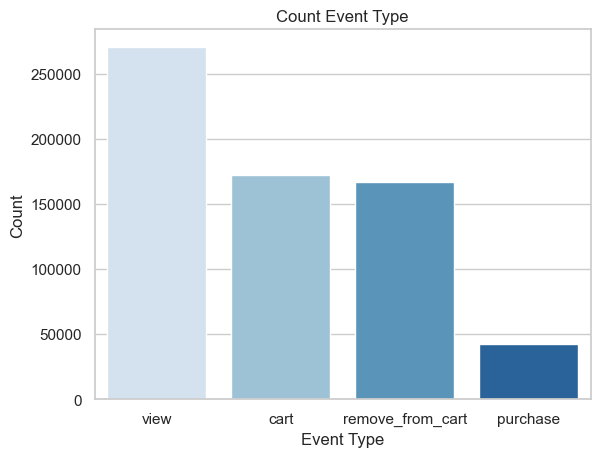

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# group by event_type and count the prices
count_df = df.groupby(['event_type'])['price'].count().reset_index(name='count')
# sort the count by descending order
count_df = count_df.sort_values(by=['count'], ascending=False)

# plot the bar chart using seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x="event_type", y="count", data=count_df, palette="Blues")
ax.set_title("Count Event Type")
ax.set(xlabel='Event Type', ylabel='Count')

plt.show()


> ### Question 6 :

In [57]:
#Creat 3 differents list of event_type for each session
a = df[df['event_type'] == "view"].groupby('user_session')['product_id'].agg(list).reset_index().rename(columns={'product_id': 'List_of_viewed'})
b= df[df['event_type'] == "cart"].groupby('user_session')['product_id'].agg(list).reset_index().rename(columns={'product_id': 'list_of_added_to_cart'})
c= df[df['event_type'] == "purchase"].groupby('user_session')['product_id'].agg(list).reset_index().rename(columns={'product_id': 'list_of_purchased'})

In [59]:
#GroupBy easy calculated fields
result = df.groupby(['user_id', 'user_session', 'funnel_number','funnel_index']).agg({
    'event_type': 'count',
    'duration_to_next_event': 'sum',
}).reset_index().rename(columns={'event_type': 'events_count','duration_to_next_event': 'session_duration (sec)'})

In [61]:
#Merged all the DF's
merged_df = result.merge(a, on='user_session', how='left').merge(b, on='user_session', how='left').merge(c, on='user_session', how='left')
merged_df.sort_values(by=['user_id','funnel_number','funnel_index'], ascending=[True,True,True]).head()

,user_id,user_session,funnel_number,funnel_index,events_count,session_duration (sec),List_of_viewed,list_of_added_to_cart,list_of_purchased
0,9794320,0757ddda-e4a6-45d3-b577-cc94a5fe1d5f,1,1,10,307.0,"[5896429, 5896429, 5896421, 5841190, 5896422, ...","[5896421, 5841190, 5896422, 5896419]",NaN
1,9794320,0906f5b2-836d-4485-bd44-79064545bd87,1,2,1,0.0,[5811668],NaN,NaN
2,9794320,09894a4f-860e-448c-83d5-691590d28617,1,3,7,144.0,"[5896429, 5866962, 5896421, 5896422, 5841195]","[5896421, 5896422]",NaN
3,9794320,0bce1dc5-7a91-44d7-921f-fbfdbf1925c2,1,4,3,24.0,"[5809910, 5724305, 5811668]",NaN,NaN
4,9794320,1caa56ab-bd6f-4e0f-957a-30d19ba4f4c0,1,5,8,4389.0,[5847854],"[5811668, 5811668, 5724608, 5724658, 5724658, ...",NaN
